# Beat the Books

#### A data science project by Jonathan Sears

### Goal
The main goal of this project is to find a way to profit of of sports betting. There are several reasons I want to do this. First I want to make money, I feel like that is pretty self explanatory. What motivated me more however is how detestable I find the gambling industry to be. Casinos and sports books will happily profit off of people with gambling addictions and have no problem marketing to underage kids. Speaking from experience I know several of my friends and have watched them throw their money away into sports betting since high school. 

### Approach
I plan on using a couple different approaches to try to beat the books. The first approach is to use an arbitrage strategy. The idea behind the arbitrage strategy is to find 2 different books with different odds on the same game with a big enough gap between them so I can bet on two different outcomes of the game and be guaranteed to win money. This is the safest approach as winning money is guaranteed but it is also the slowest, as finding situations like this is pretty rare. I plan on using webscraping to scrape data from different sports books and then analyzing the data to try to identify arbitrage opportunities. A second approach is plus EV betting. This approach is similar to arbitrage, except it is riskier, as plus EV betting forgoes the hedge bet. Although this approach is riskier in the short run, in the long run it is much more profitable, due to the law of large numbers, assuming we are properly assesing our probability of a bet hitting, we should still see some serious returns. Lastly I plan on using data from past games to try to train a machine learning model to accurately predict the odds of a team winning a game, and use that data to identify plus EV bets. 

### Potential Challenges
I think the biggest challenge I will face during this project will be finiding a way to consistently identify plus EV bets, after all if it was common knowledge which bets had the best odds everybody would be millionaires. I think the best way to go about this is to compare all of the different odds each book has for a different game and flag books that have discreppancies between the two bets and identify which book is the value bet. Another way I plan on approaching this problem is to use a machine learning model that can predict game outcomes based on past data. The biggest challenge I think I will face in the model is finding a way to calculate the differences between past games and future games, as there are so many changing variables (players, coaches, field conditions, injuries, etc.) that it could be incredibly difficult to find a way to properly use past data to predict future games. 

### Mathematical Toolbox
There are a coule important tools in our mathematical toolbox that will help me during this project. The first of these tools is expected value. The plus EV strategy relies on identifying bets with positive expected values, so it's important to have a strong understanding of what expected values are. The expected value of a bet will be:
    EV = P(event a happens)* (Payoff of event a) + P(event b) * (Payoff of event b)
    where events a and b are mutually exclusive
When looking at this we can see how important it is to properly asses the probability of a given event happening is, as that's what will be the real difference between making and losing money. 
The second important tool is the law of large numbers, which states that the more bets we place, the higher probability we have of reaching our expected value. This is important because while we might have a positive EV on a bet this doesn't guarantee that it will hit. What the law of large numbers is saying that if we place 1000 bets with 50% probability of hitting, then we have an incredibly high probability of hitting around 500 of them. Basically, the more bets we place, the closer we should get to converging to our expected value. 
The last important tool us the kelly criterion, which is a simpe mathematical formula we can use to size our bets. 
- Expected Value
- Law Of Large Numbers
- Kelly Criterion


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


First lets read in our data and drop the games without betting data, as we won't have much use for them.

In [3]:
games = pd.read_csv('./Data/spreadspoke_scores.csv')
teams = pd.read_csv('./Data/nfl_teams.csv')
stadiums = pd.read_csv('./Data/nfl_stadiums.csv', encoding="unicode_escape")


games.dropna(subset='spread_favorite', inplace=True)
games.dropna(subset='over_under_line', inplace=True)
games.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
350,1/14/1968,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,43.0,Orange Bowl,True,60.0,12.0,74.0,NaN
538,1/12/1969,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,40.0,Orange Bowl,True,66.0,12.0,80.0,rain
727,1/11/1970,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39.0,Tulane Stadium,True,55.0,14.0,84.0,rain
916,1/17/1971,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,36.0,Orange Bowl,True,59.0,11.0,60.0,NaN
1105,1/16/1972,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34.0,Tulane Stadium,True,34.0,18.0,40.0,NaN


Let's make some new columns indicating the winner of the game, who covered the spread, and if the over hit. Any pushes or ties will be replaced with NaN's

In [4]:
def winner(df):
    if df['score_home'] > df['score_away']:
        return df['team_home']
    elif df['score_away'] > df['score_home']:
        return df['team_away']
    else:
        return None
    
def over(df):
    if float(df['score_home'] + df['score_away']) > float(df['over_under_line']):
        return True
    elif float(df['score_home'] + df['score_away']) < float(df['over_under_line']):
        return False
    else:
        return None

# def covered(df):
#     if df['score_home'] - df['score_away'] > df['spread_favorite']:
        

games['winner'] = games.apply(winner, axis = 1)
games['over'] = games.apply(over, axis = 1)
games.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,winner,over
350,1/14/1968,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,43.0,Orange Bowl,True,60.0,12.0,74.0,NaN,Green Bay Packers,True
538,1/12/1969,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,40.0,Orange Bowl,True,66.0,12.0,80.0,rain,New York Jets,False
727,1/11/1970,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39.0,Tulane Stadium,True,55.0,14.0,84.0,rain,Kansas City Chiefs,False
916,1/17/1971,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,36.0,Orange Bowl,True,59.0,11.0,60.0,NaN,Baltimore Colts,False
1105,1/16/1972,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34.0,Tulane Stadium,True,34.0,18.0,40.0,NaN,Dallas Cowboys,False


In [5]:
games['over'].value_counts()


over
False    5492
True     5304
Name: count, dtype: int64

<Axes: xlabel='schedule_season', ylabel='spread_favorite'>

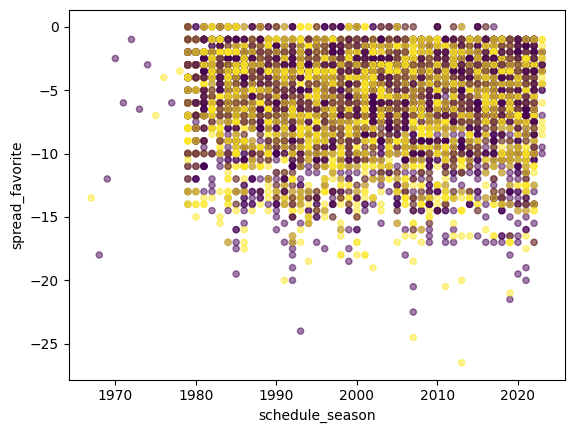

In [6]:
#TODO
#analyze trends in games that hit the over (was it an in-division game? How tight was the spread?)
games['over'].map({True:'green', False:'red', None:'black'})
games.plot.scatter(x='schedule_season', y='spread_favorite',c='over', alpha=.5)

Since the different colored dots are evenly distributed, it doesn't look like the size of the spread of a game has much impact on whether the over hits or not. What about the weather? Let's look at games played in freezing temperatures and see if that makes an impact on the over hitting

over
True     307
False    283
Name: count, dtype: int64

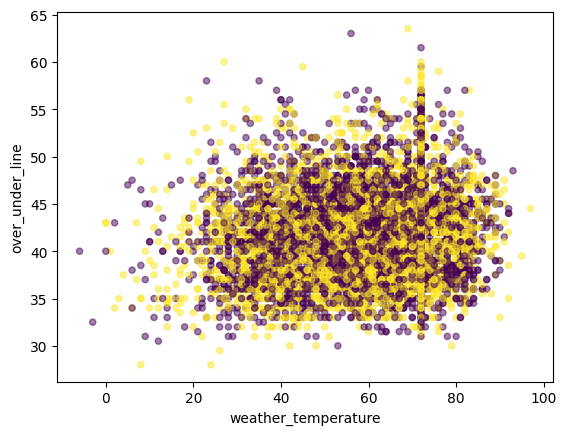

In [13]:
games.plot.scatter(x='weather_temperature', y='over_under_line', c='over', alpha = .5)
freezing = games[games['weather_temperature'] <= 32]
freezing['over'].value_counts()